In [1]:
# import packages
import numpy as np

from scipy.optimize import minimize
from scipy.optimize import fsolve
import scipy.stats as stats

import statsmodels.api as sm
import matplotlib.pyplot as plt
from functools import partial

import warnings
warnings.filterwarnings("ignore")

# Maximum likelihood estimation (MLE)

## Example 1: Normal distribution

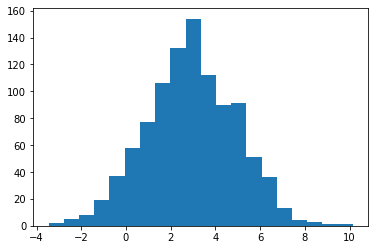

In [2]:
raw_data1 = np.loadtxt('https://fmai-teaching.s3.amazonaws.com/bia652/est/n.txt')
histogram = plt.hist(raw_data1, bins=20)

In [3]:
raw_data1[0]

0.8287387933988777

In [4]:
# the likelihood of first data point when mu = 0, sigma = 1
stats.norm.pdf(raw_data1[0], loc=0, scale=1)

0.2829903369296451

In [5]:
# the likelihood of first data point when mu = 10, sigma = 10
stats.norm.pdf(raw_data1[0], loc=10, scale=10)

0.026197696634403057

In [6]:
# suppose we posit that the data is generated by a normal distribution
# now we find the parameters in normal distribution that most likely generated the data

# now let's define a function to optimize 
def negLL_Norm(params, raw_data):
    mu, sigma = params[0], params[1]

    # Log likelihood function of the entire data (sum of the log(f(x_i|parameters)) of each data point x_i)
    LL = np.sum(stats.norm.logpdf(raw_data, loc=mu, scale=sigma))

    # minimize the negative log likelihood
    negLL = -LL

    return(negLL)

In [7]:
print(negLL_Norm(params=(2, 3), raw_data = raw_data1)) # mu = 2, sigma = 3, what is the -LL of the entire data?
print(negLL_Norm(params=(1, 1), raw_data = raw_data1)) # mu = 1, sigma = 1, what is the -LL of the entire data?

2287.2345729907456
4766.964021104756


In [8]:
result = minimize(partial(negLL_Norm, raw_data=raw_data1), x0=(2, 3), method = 'Nelder-Mead', options={'disp': True})

print("\n", 
      "The parameters we get from MLE: ", "\n", 
      "MLE estimate mean (mu-hat): ", result['x'][0], "\n",
      "MLE estimate std (sigma-hat): ", result['x'][1], "\n",
      )

Optimization terminated successfully.
         Current function value: 2112.872942
         Iterations: 37
         Function evaluations: 72

 The parameters we get from MLE:  
 MLE estimate mean (mu-hat):  2.920837589685381 
 MLE estimate std (sigma-hat):  2.0015508600382397 



## Example 2

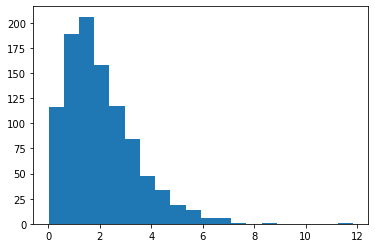

In [9]:
raw_data2 = np.loadtxt('https://fmai-teaching.s3.amazonaws.com/bia652/est/g.txt')
histogram = plt.hist(raw_data2, bins=20)

In [10]:

# let's assume that the data is generated from a gamma distribution
def negLL_Gama(params, raw_data):
    
    alpha, beta = params[0], params[1]
    LL = np.sum(stats.gamma.logpdf(raw_data, alpha, scale=(1/beta))) # scale = 1/beta, pay attention to the parameterization of gamma distribution 
    negLL = -LL
    
    return(negLL)

In [11]:
result = minimize(partial(negLL_Gama, raw_data=raw_data2), x0 = (0, 1), method = 'Nelder-Mead', options={'disp': True})

print("\n", 
      "The parameters we get from MLE: ", "\n", 
      "MLE estimate alpha-hat: ", result['x'][0], "\n",
      "MLE estimate beta-hat: ", result['x'][1], "\n"
      )

Optimization terminated successfully.
         Current function value: 1586.325395
         Iterations: 75
         Function evaluations: 145

 The parameters we get from MLE:  
 MLE estimate alpha-hat:  2.0572400127515262 
 MLE estimate beta-hat:  1.0108753149456442 



Sometimes we may mis-specify the model, for example, we mistakenly assumed that raw_data2 is generated by a Normal distribution. 

In [12]:
result = minimize(partial(negLL_Norm, raw_data=raw_data2), x0 = (0, 1), method = 'Nelder-Mead', options={'disp': True})

print("\n", 
      "The parameters we get from MLE: ", "\n", 
      "MLE estimate mu-hat: ", result['x'][0], "\n",
      "MLE estimate sigma-hat: ", result['x'][1], "\n"
      )

Optimization terminated successfully.
         Current function value: 1747.123330
         Iterations: 86
         Function evaluations: 163

 The parameters we get from MLE:  
 MLE estimate mu-hat:  2.035053335666178 
 MLE estimate sigma-hat:  1.3884431021158514 



What if we mistakenly assumed that raw_data2 is generated by an exponential distribution? Note that it has a single parameter (mu or scale).  

In [13]:
def negLL_Exp(mu, raw_data):
    LL = np.sum(stats.expon.logpdf(raw_data, scale=mu))
    negLL = -LL

    return(negLL)

result = minimize(partial(negLL_Exp, raw_data=raw_data2), x0 = ((0.5)),  options={'disp': True})

print("\n", 
      "The parameters we get from MLE: ", "\n", 
      "MLE estimate mu-hat: ", result['x'][0], "\n",
      )

Optimization terminated successfully.
         Current function value: 1710.533830
         Iterations: 10
         Function evaluations: 22
         Gradient evaluations: 11

 The parameters we get from MLE:  
 MLE estimate mu-hat:  2.0350773810457423 



# Method of Moments (MoM)

## Normal distribution

In [14]:
# MoM matches sample moments with the RV moments to estimate the parameters
# for example, for normal distribution, we need to estimate the mean and std
# so we only need the first two moment

print("MoM estimates \n",
      "mean (mu-hat): ", np.mean(raw_data1), "\n",
      "std dev (sigma-hat): ", np.std(raw_data1), "\n")

MoM estimates 
 mean (mu-hat):  2.9208717278384166 
 std dev (sigma-hat):  2.001575075032467 



## Gamma distribution

In [15]:
# the mean (first moment) of gamma distribution is: alpha/beta
# the variance (2nd central moment) of gamma distribution is: alpha/beta^2

# we only have two unknown variables
# so we solve the following systems of equations using fsolve using the first two moments:
# alpha/beta = np.mean(raw_data) --> alpha/beta - np.mean(raw_data) = 0
# alpha/(beta**2) = np.var(raw_data) --> alpha/(beta**2) - np.var(raw_data) = 0


# let's use python to build a formula solver
def fun_1(z):

    alpha = z[0]
    beta = z[1]

    F = np.empty((2))
    F[0] = alpha / beta - np.mean(raw_data2)
    F[1] = alpha / (beta ** 2) - np.var(raw_data2)

    return F


results = fsolve(fun_1, x0=np.array([1, 1])) # 1,1 are the initial guesses

print(
    "MoM estimates \n", "alpha-hat: ", results[0], "\n", "beta-hat: ", results[1], "\n"
)



MoM estimates 
 alpha-hat:  2.1483456160180205 
 beta-hat:  1.0556579644371937 

